# Predicting Airline Data using a Generalized Linear Model (GLM) in Python3

In particular, we will predict the probability that a flight is late based on its departure date/time, the expected flight time and distance, the origin and destitation airports.

The core library for the dataframe part is [pandas](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html).<br>
The core library for the machine learning part is [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression).

### Considerations

The objective of this notebook is to define a simple model offerring a point of comparison in terms of computing performances across datascience language and libraries.  In otherwords, this notebook is not for you if you are looking for the most accurate model in airline predictions.  

## Install and Load useful libraries

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

## Load the data

- The dataset is taken from [http://stat-computing.org](http://stat-computing.org/dataexpo/2009/the-data.html).  We take the data corresponding to year 2008.
- We restrict the dataset to the first million rows
- We print all column names and the first 5 rows of the dataset

In [3]:
df = pd.read_csv("2008.csv")
df.shape[0]

7009728

In [4]:
df = df[0:1000000]

In [5]:
df.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

In [6]:
df[0:5]

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,3.0,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,926.0,930,1054.0,1100,WN,1746,...,3.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,...,3.0,10.0,0,NaN,0,2.0,0.0,0.0,0.0,32.0


## Data preparation for training

- We turn origin/destination categorical data to a "one-hot" encoding representation
- We create a new "binary" column indicating if the flight was delayed or not.
- We show the first 5 rows of the modified dataset
- We split the dataset in two parts:  a training dataset and a testing dataset containing 80% and 20% of the rows, respectively.

In [7]:
df = pd.concat([df, pd.get_dummies(df["Origin"], prefix="Origin")], axis=1);
df = pd.concat([df, pd.get_dummies(df["Dest"  ], prefix="Dest"  )], axis=1);
df = df.dropna(subset=["ArrDelay"]) 
df["IsArrDelayed" ] = (df["ArrDelay"]>0).astype(int)
df[0:5]

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,Dest_TYR,Dest_TYS,Dest_VLD,Dest_VPS,Dest_WRG,Dest_XNA,Dest_YAK,Dest_YKM,Dest_YUM,IsArrDelayed
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,0,0,0,0,0,0,0,0,0,0
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,0,0,0,0,0,0,0,0,0,1
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,0,0,0,0,0,0,0,0,0,1
3,2008,1,3,4,926.0,930,1054.0,1100,WN,1746,...,0,0,0,0,0,0,0,0,0,0
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,...,0,0,0,0,0,0,0,0,0,1


In [8]:
train = df.sample(frac=0.8)
test  = df.drop(train.index)

## Model building

- We define the generalized linear model using a binomial function --> Logistic regression.
- We train the model and measure the training time --> ~15sec on an intel i7-6700K (4.0 GHz) for 800K rows 	
- We show the model coefficients
- We show the 10 most important variables

In [9]:
#get the list of one hot encoding columns
OriginFeatCols = [col for col in df.columns if ("Origin_" in col)]
DestFeatCols   = [col for col in df.columns if ("Dest_"   in col)]
features = train[["Year","Month",  "DayofMonth" ,"DayOfWeek", "DepTime", "AirTime", "Distance"] + OriginFeatCols + DestFeatCols  ]
labels   = train["IsArrDelayed"]

In [22]:
model = LogisticRegression(C=1E5, max_iter=10000)
model.fit(features, labels)
model

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=10000,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [24]:
coef = pd.DataFrame(data=np.transpose(model.coef_), index=features.columns, columns=["Coef"])
coef = coef.reindex( coef["Coef"].abs().sort_values(axis=0,ascending=False).index )  #order by absolute coefficient magnitude
coef[ coef["Coef"].abs()>0 ] #keep only non-null coefficients
coef[ 0:10 ] #keep only the 10 most important coefficients

,Coef
Dest_LIH,-2.471914
Dest_SJU,2.308827
Origin_HNL,2.260525
Dest_OGG,-2.210733
Dest_ITO,-2.123040
Dest_KOA,-2.053880
Dest_CPR,-2.049727
Origin_KOA,2.031503
Origin_ISP,-1.969796
Dest_STT,1.933882


## Model testing

- We add a model prediction column to the testing dataset
- We show the first 10 rows of the test dataset (with the new column)
- We show the model ROC curve
- We measure the model Area Under Curve (AUC) to be 0.706 on the testing dataset.  

This is telling us that our model is not super accurate  (we generally assume that a model is raisonable at predicting when it has an AUC above 0.8).  But, since we are not trying to build the best possible model, but just show comparison of data science code/performance accross languages/libraries.
If none the less you are willing to improve this result, you should try adding more feature column into the model.

In [25]:
testFeature = test[["Year","Month",  "DayofMonth" ,"DayOfWeek", "DepTime", "AirTime", "Distance"] + OriginFeatCols + DestFeatCols  ]
test["IsArrDelayedPred"] = model.predict_proba( testFeature )[:,1]
test[0:10]

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,Dest_TYS,Dest_VLD,Dest_VPS,Dest_WRG,Dest_XNA,Dest_YAK,Dest_YKM,Dest_YUM,IsArrDelayed,IsArrDelayedPred
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,0,0,0,0,0,0,0,0,0,0.531541
5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,378,...,0,0,0,0,0,0,0,0,1,0.442708
10,2008,1,3,4,706.0,700,916.0,915,WN,100,...,0,0,0,0,0,0,0,0,1,0.277655
22,2008,1,3,4,1900.0,1840,1956.0,1950,WN,717,...,0,0,0,0,0,0,0,0,1,0.385645
31,2008,1,3,4,1008.0,1005,1234.0,1255,WN,543,...,0,0,0,0,0,0,0,0,0,0.180475
32,2008,1,3,4,712.0,710,953.0,1000,WN,1112,...,0,0,0,0,0,0,0,0,0,0.232026
33,2008,1,3,4,1312.0,1300,1546.0,1550,WN,1397,...,0,0,0,0,0,0,0,0,0,0.284691
39,2008,1,3,4,1424.0,1355,1531.0,1520,WN,2871,...,0,0,0,0,0,0,0,0,1,0.174164
44,2008,1,3,4,1153.0,1140,1428.0,1440,WN,2006,...,0,0,0,0,0,0,0,0,0,0.173347
48,2008,1,3,4,1450.0,1435,1806.0,1745,WN,3244,...,0,0,0,0,0,0,0,0,1,0.609984


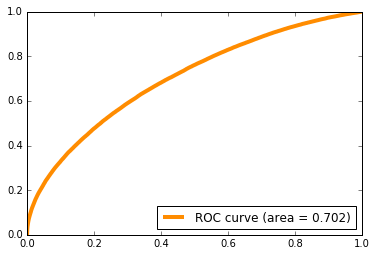

In [31]:
fpr, tpr, _ = roc_curve(test["IsArrDelayed"], test["IsArrDelayedPred"])
AUC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=4, label='ROC curve (area = %0.3f)' % AUC)
plt.legend(loc=4)

In [27]:
AUC

0.70234005786568032

## Key takeaways

- We built a GLM model predicting airline delay probability
- We train it on 800K rows in ~15sec on an intel i7-6700K (4.0 GHz)
- We measure an AUC of 0.702, which is not super accurate but reasonable
- We demonstrated a typical workflow in python language in a Jupyter notebook

I might be biased, but I find the [pandas](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html)/[scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) documentation particularly complete and easy to read.  In addition they are thousdands of recent examples/tutorials all over the web.